## Geospatial Data Scientist Census Activity
**Author:** Nicole Pepper

**Date:** 11/21/2025

**GitHub Repo:** https://github.com/nicolelpepper/af-census-activity

### 1) Set Up Workspace

In [52]:
# ---- Load libraries ----
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import re
from rasterio.mask import mask
from rasterstats import zonal_stats
from rasterio.plot import show
import matplotlib.pyplot as plt
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore")

### 2) Load Project Data

In [37]:
# ---- Read in project data ----

# american community survey data
acs = pd.read_csv("data/raw/ACSDP5Y2023.DP05_2025-11-17T173744/ACSDP5Y2023.DP05-Data.csv")

# landcover data
landcover = rasterio.open("data/raw/landcover/landcover_conus.tif")

# schools data
private_schools = gpd.read_file("data/raw/schools/EDGE_GEOCODE_PRIVATESCH_2122/EDGE_GEOCODE_PRIVATESCH_2122.shp").to_crs(landcover.crs)
public_schools = gpd.read_file("data/raw/schools/EDGE_GEOCODE_PUBLICSCH_2324/EDGE_GEOCODE_PUBLICSCH_2324.shp").to_crs(landcover.crs)

# census tracts data for 2025 (choose a state)
florida_tracts = gpd.read_file("data/raw/tracts/12/tl_2025_12_tract.shp").to_crs(landcover.crs)
# oregon_tracts = gpd.read_file("data/raw/tracts/41/tl_2025_41_tract.shp")
# pennsylvania_tracts = gpd.read_file("data/raw/tracts/42/tl_2025_42_tract.shp")

### 3) Explore & Clean Data

##### Prep American Community Survey (acs) Data

In [38]:
# --- Explore & prep american community survey data ----

# Check column names
acs.columns

# Get snapshot of data
acs.head

# Save 1st row as metadata for columns (bc there are two header rows)
metadata_row = acs.iloc[0]
col_metadata = metadata_row.to_dict()
# print(col_metadata)

# Drop extra header and reset index
acs = acs.drop(index=0).reset_index(drop=True)
# acs.head

# ---- Select demographic data for Florida ----

# Select primary id fields and 2 demographic statistics of choice: 0037PE (percent white) and DP05_0071PE (percent hispanic)
acs = acs[["GEO_ID", "NAME", "DP05_0001E","DP05_0037PE", "DP05_0071PE"]] 

# filter to Florida
fl_acs = acs[acs["GEO_ID"].str.contains("1400000US12")]

# ---- Clean errors in population statistics columns ----

# Select population statistics columns (total pop, percent white, percent hispanic)
pop_cols = ["DP05_0001E","DP05_0037PE","DP05_0071PE"]

# Force non-numeric values in population stat columns to NA
fl_acs[pop_cols] = fl_acs[pop_cols].apply(
    pd.to_numeric,
    errors="coerce")

##### Prep Schools Data

In [39]:
# ---- Explore & prep schools data -----

# Explore data
public_schools.head
private_schools.head

# Add descriptive column for school types
public_schools["school_type"] = "public_schools"
private_schools["school_type"] = "private_schools"

# Join schools data
schools = pd.concat([public_schools, private_schools], ignore_index = True)

In [40]:
# --- Count schools in florida tracts ----

# Left join schools with florida tracts 
schools_in_florida = gpd.sjoin(
    florida_tracts,
    schools,
    how = "left",
    predicate = "intersects")

schools_in_florida

# Count schools per tract unique tract using GEOID
school_counts = (schools_in_florida
                 .groupby(["GEOIDFQ","school_type"])
                 .size()
                 .unstack(fill_value = 0)
                 .reset_index())


##### Prep landcover data

In [41]:
# ---- Clip landcover data to Florida ----

# Dissolve florida tracts to get clipping boundary
fl_union = florida_tracts.unary_union

# Clip landcover to Florida
landcover_clip, landcover_transform = mask(landcover,
                                           [fl_union],
                                           crop = True)
landcover_array = landcover_clip[0]

# Check unique values in landcover (turns out that it's already filtered to only forest cover!)
np.unique(landcover_array)

array([-128,   41,   42,   43], dtype=int16)

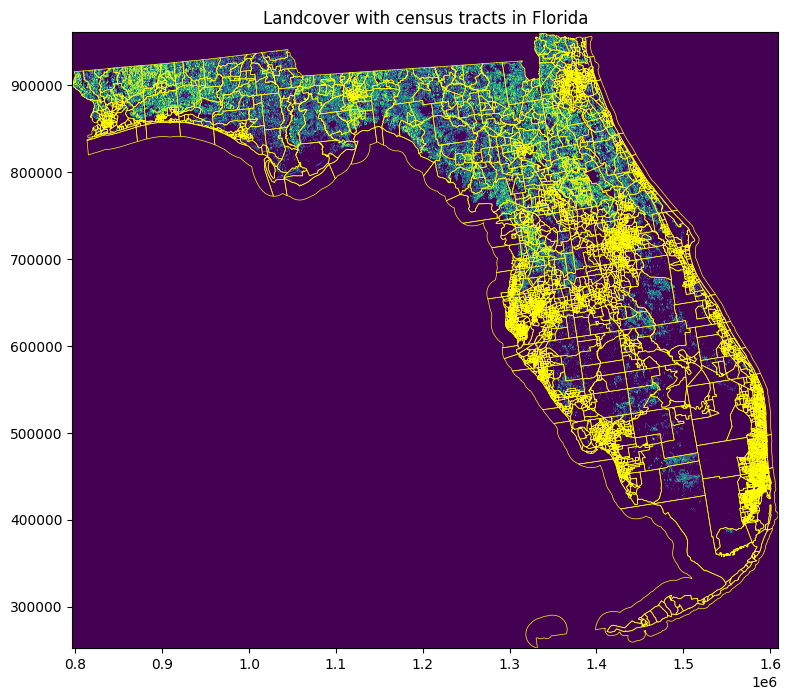

In [42]:
# ---- Map landcover and census tracts to check data----
fig, ax = plt.subplots(figsize=(10, 8))

# Plot florida landcover
rasterio.plot.show(landcover_array,
                   ax = ax,
                   transform = landcover_transform)
# Add Florida census tracts
florida_tracts.boundary.plot(ax = ax,
                             edgecolor = "yellow",
                             linewidth = 0.5)

ax.set_title("Landcover with census tracts in Florida")
plt.show()

In [43]:
# ---- Perform zonal statistics on florida landcover ----

# Define value for nodata
nodata = landcover.nodata

# Calculate zonal stats
landcover_count = zonal_stats(
    florida_tracts,
    landcover_array,
    affine = landcover_transform,
    categorical = True,
    nodata = nodata)

In [44]:
# ---- Calculate total forested pixels per census tract ----

# Define forest classes
forest_classes = [41, 42, 43]

# Create a function to count pixels for all forest classes
def compute_forest_pixels(zonal_stats_list, forest_classes):
    return [
        sum(counts.get(fc, 0) for fc in forest_classes)
        for counts in zonal_stats_list
    ]

# Apply function to compute forested pixel area per tract
forest_pixels = compute_forest_pixels(landcover_count, forest_classes)


### 4) Merge Datasets

##### Join ACS Data with Florida Tracts

In [45]:
# ---- Join acs data to florida tracts ----

# Left join school counts on florida tracts
florida_tracts = florida_tracts.merge(
    fl_acs,
    how = "left",
    left_on = "GEOIDFQ",
    right_on = "GEO_ID")

##### Join forest cover data to Florida tracts

In [46]:
# ---- Join forest cover data to florida tracts----

# Add forested pixel counts to florida tracts
florida_tracts["forest_pixels"] = forest_pixels

# Calculate forested area by converting area to m2 by multiplying by 900 bc 30 x 30m resolution
florida_tracts["forest_area_m2"] = (
    florida_tracts["forest_pixels"] * 900)


In [47]:
# ---- Calculate forest spatial statistics -----

# Calculate percent forest cover
florida_tracts["pct_forest_cover"] = np.where(
    # Avoid divison by zero
    florida_tracts["ALAND"] > 0,
    (florida_tracts["forest_area_m2"]/florida_tracts["ALAND"])*100,
    np.nan)

# Calculate trees per capita
florida_tracts["trees_per_capita"] = np.where(
    # Avoid divison by zero
    florida_tracts["DP05_0001E"] > 0,
    # Convert 600 sqft to ms (1 sq ft = 0.092903 sq ms) 600 x 0.092903 = 55.7418
    florida_tracts["forest_area_m2"] / 55.7418 / florida_tracts["DP05_0001E"],
    np.nan)

##### Join school data to Florida tracts

In [48]:
# ---- Join school data to florida tracts ---

# Left join school counts on florida tracts
florida_tracts = florida_tracts.merge(
    school_counts,
    how = "left",
    on = "GEOIDFQ")

# ---- Calculate school statistics ----

# Fill NAs with 0s
florida_tracts[["public_schools", "private_schools"]] = (
    florida_tracts[["public_schools", "private_schools"]]
    .fillna(0)
    .astype(int))

# Calculate total schools per tract
florida_tracts["total_schools"] = (florida_tracts["public_schools"] + florida_tracts["private_schools"])

# Calculate schools per capita
florida_tracts["schools_per_capita"] = np.where(

    # Avoid division by 0
    florida_tracts["DP05_0001E"] > 0,
    
    # Calculate schools per capita
    florida_tracts["total_schools"]/ florida_tracts["DP05_0001E"],
    np.nan)

# Calculate ratio of public schools to private schools (ranges to 0-1, where 1 = all public, 0 = all private, .5 = 50/50 split)
florida_tracts["public_school_ratio"] = (florida_tracts["public_schools"] /
                                         (florida_tracts["private_schools"] + florida_tracts["public_schools"]))

### 5) Summarize Data

In [49]:
# ---- Select columns for summary table ----
florida_summary = florida_tracts[["GEOID",
                                  "DP05_0001E",
                                  "DP05_0037PE",
                                  "DP05_0071PE",
                                  "pct_forest_cover",
                                  "trees_per_capita",
                                  "public_school_ratio",
                                  "schools_per_capita"]]

# Rename columns
florida_summary = florida_summary.rename(columns={
    "GEOID": "Census Tract ID (GEOID)",
    "DP05_0001E": "Total Population",
    "DP05_0037PE" : "Percent White",
    "DP05_0071PE" : "Percent Hispanic",
    "pct_forest_cover": "Percent Forest Cover",
})

# Change string formatting to title case
florida_summary.columns = (florida_summary
                           .columns
                           .str.replace("_", " ")
                           .str.title())

# Limit significant digits for pct forest cover
florida_summary["Percent Forest Cover"] = (
    florida_summary["Percent Forest Cover"].round(2))

# Sort by Total Population
florida_summary = florida_summary.sort_values(
    by = "Total Population",
    ascending = False)

In [56]:
# Print table for the 50 census blocks with the largest populations
HTML(florida_summary.head(50).to_html(index = False))

Census Tract Id (Geoid),Total Population,Percent White,Percent Hispanic,Percent Forest Cover,Trees Per Capita,Public School Ratio,Schools Per Capita
12011010503,24659,56.8,0.0,0.03,0.005238,1.000000,0.000122
12095017111,21231,53.9,9.1,2.88,2.508842,1.000000,0.000283
12095016802,21155,53.0,0.0,4.10,3.012421,1.000000,0.000284
12031014423,20727,66.8,0.8,22.64,22.631642,1.000000,0.000145
12109020605,19426,83.1,0.8,11.27,6.073195,1.000000,0.000154
12057013916,18807,39.2,1.4,4.20,0.606103,0.750000,0.000213
12105012502,18044,39.5,1.6,3.56,2.938542,1.000000,0.000222
12019030205,17442,49.1,1.5,28.00,8.233081,1.000000,0.000229
12095017112,16633,62.7,0.2,1.27,0.165992,1.000000,0.000120
12095017113,16277,73.3,0.1,4.17,1.621828,0.800000,0.000307


In [51]:
# Export summary table as csv
# In the real world I would export this with the column names in lower_snakecase or whatever the preferred format is
output_path = "data/processed/florida_summary.csv"
florida_summary.to_csv(output_path,
                       index = False)

### 6) Documentation:

I approached this exercise as a data wrangling and exploratory analysis workflow. I structured my notebook following a standard sequence: import, cleaning, and then summarization. Throughout the document I kept detailed comments to document the workflow. I began by importing each dataset and taking time to understand the attirbute fields, NA patterns, and value distributions. Knowing that I would need to join the datasets across attributes and space, I identified a common field for the attribute joins and reprojected spatial data to a common CRS. To keep data processing efficient, I clipped and filtered layers as I went.

One speed bump that I ran into was with the NLCD landcover layer. The assignment instructions had referenced removing water and shrub/scrub categories, so I expected the full range of NLCD classes, however the raster that I was provided only contained three forest classes and a single class for everything else. It took me some troubleshooting before I understood the limitation of the dataset and moved forward with aggregating the forest classes and using the land area field from the census data. Additionally, interpreting the American Community Survey (ACS) metadata was tricky, so I relied on external documentation to validate the columns that I selected. During the summarization stage, I encountered a divison-by-zero issue that produced "infiinity" values in the percest forest cover and per capita metrics. To resolve this I added conditional logic to ensure the calculations were only performed where population or land area was greater than 0.

Overall, I found the exercise both interesting and a valuable opporunity to practice integrating the datasets into meaningful indicators. I went over the 2 hours, but the process helped freshed up my Python skill since I've been using R more as of lately. If I had more time with this project, I'd be curious to explore patterns in the resulting metrics.